# Contenuti
- [Descrizione del dataset](#Descrizione-del-dataset)
- [Pandas](#Pandas)
    - [Esplorazione dei dati](#Esplorazione-dei-dati)
    - [Preprocessing dei dati](#Preprocessing-dei-dati)
    - [Predizione all'ora successiva](#Predizione-all'ora-successiva)
    - [Split validation set](#Split-validation-set)
- [Regressione in Scikit-Learn](#Regressione-in-Scikit-Learn)
- [Ottimizzazione dei parametri](#Ottimizzazione-dei-parametri)
- [Test](#Test)

# Esercitazione 5
Nell'esercitazione odierna si vedrà come applicare i regressori *lineare* e *Random Forest* a un problema reale. La lezione è suddivisa in tre parti:

- introduzione alla libreria **Pandas**;
- introduzione alla regressione in **Scikit-learn**;
- risoluzione del problema.

Nel corso dell'esercitazione si dovranno individuare le combinazioni di iperparametri che permettono di minimizzare l'RMSE (*Root Mean Squared Error*) sul dataset fornito utilizzando *Cross-Validation* e *Grid Search*.

Infine si dovrà verificare l’effettiva capacità di generalizzazione della soluzione trovata sul dataset di test.

# Descrizione del dataset

Obiettivo di questa esercitazione è quello di creare un modello di regressione in grado di prevedere la quantità di energia prodotta da un impianto fotovoltaico. Il dataset è relativo a un impianto fotovoltaico reale di 960 kWP ubicato a Lecce. Il dataset:

- contiene circa 15000 record relativi a medie orarie su un periodo di poco meno di 2 anni (500 giorni);
-  la variabile **indipendente** è costituita dal vettore 6-dimensionale [Ora, Data, Temperatura ambiente, Temperatura dei moduli, Irraggiamento dei pannelli inclinati a 3 gradi, Irraggiamento dei pannelli inclinati a 15 gradi];
-  la **variabile dipendente** (valore *target*) è costituita dalla produzione in kWH dell'impianto in una determinata ora.

Di seguito vengono forniti i riferimenti per ulteriori approfondimenti:
- M. Malvoni, M. G. De Giorgi, P. M. Congedo, [*Data on photovoltaic powerforecasting models for Mediterranean climate*](https://www.sciencedirect.com/science/article/pii/S2352340916302773), Data in Brief, 2016.
- M. G. De Giorgi, M. Malvoni, P. M. Congedo, [*Comparison of strategies for multi-step ahead photovoltaic power forecasting models based on hybrid group method of data handling networks and least square support vector machine*](https://www.sciencedirect.com/science/article/abs/pii/S0360544216304261), Energy, 2016.

# Pandas
**Pandas** è una libreria python per la manipolazione e analisi di dati multidimensionali. Fornisce diversi metodi per la visualizzazione e analisi statistica dei dati e pertanto risulta molto utile per condurre un'esplorazione iniziale. È in grado di caricare dataset forniti nei formati più conosciuti ed è in grado di gestire feature eterogenee e serie temporali.

Il codice contenuto nella cella seguente esegue l'import della libreria. Per convenzione la libreria è solitamente importata con il nome **pd**.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Pandas è in grado di caricare dataset in formato CSV attraverso la funzione **read_csv(...)**. Questa funzione carica in memoria il contenuto del file restituendo una istanza della classe **DataFrame**. A differenza degli **ndarray**, nei **DataFrame** ogni colonna (feature) è identificata da un nome (definito nell'*header* del CSV) e ogni feature può essere di tipo differente.

La cella seguente mostra come richiamare **read_csv(...)** per caricare un dataset in memoria.

In [2]:
filePath = 'train.txt'

dataframe = pd.read_csv(filePath)
print(type(dataframe))

<class 'pandas.core.frame.DataFrame'>


## Esplorazione dei dati

La classe **DataFrame** espone diversi metodi per ottenere informazioni di sintesi riguardanti i dati appena caricati.

Il metodo **.info()** permette di stampare a video cardinalità, features e tipi di dati caricati.

In [3]:
# Stampa di informazioni sulle features (colonne): cardinalità e tipo
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time Frame  7902 non-null   int64  
 1   Date        7902 non-null   object 
 2   Ta (C)      7902 non-null   float64
 3   Tm (C)      7902 non-null   float64
 4   I3 (W/m2)   7902 non-null   float64
 5   I15 (W/m2)  7902 non-null   float64
 6   P (kW)      7902 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 432.3+ KB


Il metodo **.describe()** restituisce un insieme di informazioni statistiche riguardanti le diverse feature. Vengono riportati i valori minimi e massimi così come la media, la deviazione standard e il 25-, 50-, 75- e 100-percentile. Si noti come Jupyter sia in grado di individuare e formattare ad-hoc il risultato di **.describe()**.

In [4]:
# Stampa delle statistiche aggregate sulle features
dataframe.describe()

# Jupyter gestisce direttamente il risultato di describe() presentandolo adeguatamente
# Si noti la differenza di output decommentando la seguente riga:
#print(dataframe.describe())

,Time Frame,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
count,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000
mean,12.492407,15.089675,17.755080,203.455206,214.903907,161.668209
std,6.917957,11.683758,16.641611,291.878650,306.698855,234.276655
min,1.000000,-1.460000,-7.130000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,15.535000,14.885000,8.545000,9.785000,4.295000
75%,18.000000,24.037500,28.637500,364.795000,380.785000,292.362500
max,24.000000,43.530000,70.140000,1031.550000,1051.230000,806.610000


Allo stesso modo è possibile visualizzare alcuni dei pattern relativi al **DataFrame**. 
L'output della cella seguente mostrerà alcuni dei primi e ultimi pattern del dataset. Da questa prima esplorazione risulta chiaro che i pattern sono ordinati temporalmente.

In [5]:
dataframe

,Time Frame,Date,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3/5/12 4:55 PM,13.01,12.05,52.47,53.08,6.50
1,17,3/5/12 5:55 PM,11.81,8.50,10.41,10.95,0.01
2,18,3/5/12 6:55 PM,10.33,5.68,0.00,0.00,0.00
3,19,3/5/12 7:55 PM,9.66,4.67,0.00,0.00,0.00
4,20,3/5/12 8:55 PM,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...,...,...
7897,2,2/1/13 9:45 PM,0.00,0.00,0.00,0.00,0.00
7898,3,2/1/13 9:45 PM,0.00,0.00,0.00,0.00,0.00
7899,4,2/2/13 4:55 AM,10.25,6.83,0.00,0.00,0.00
7900,5,2/2/13 5:55 AM,10.54,8.06,0.00,0.00,0.00


Essendo Pandas ampiamente utilizzato in ambito Machine Learning e Data Science, son disponibili *plugin* o customizzazioni di Jupyter per permettere un'esplorazione più interattiva dei dati. Ad esempio, Google Colaboratory offre [un'estensione ad hoc](https://twitter.com/GoogleColab/status/1190349318617583616) per trattare la visualizzazione di **DataFrame**.

Inoltre, la classe **DataFrame** offre la possibilità di visualizzare graficamente la distribuzione dei valori delle feature sotto forma di istogrammi. Attraverso la visualizzazione grafica della distribuzione dei valori è possibile individuare tra le varie cose anomalie e la presenza di dati mancanti.

La visualizzazione grafica è demandata alla libreria Matplotlib.

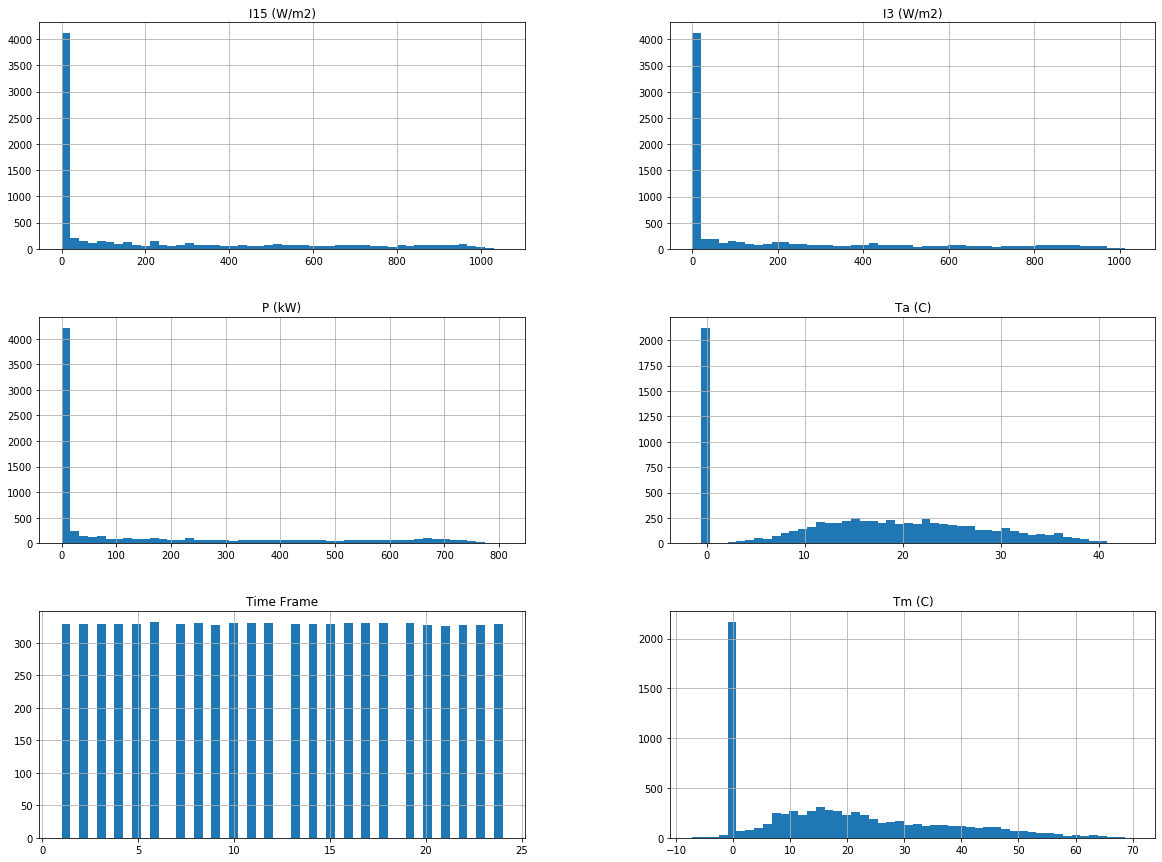

In [6]:
# Visualizzazione grafica della distribuzione dei valori delle features (istogrammi)
dataframe.hist(bins=50, figsize=(20,15))
plt.show()

Durante la prima analisi dei dati può essere utile individuare eventuali correlazioni tra le diverse feature. È possibile utilizzare il metodo **.corr()** per calcolare i coefficienti di correlazione. Nella cella seguente verranno stampati a video i coefficienti relativi alla correlazione tra le diverse feature rispetto all'etichetta "P (kW)".

In [7]:
# Calcolo dei coefficienti di correlazione tra le features
corr_matrix = dataframe.corr()

# Stampa dei coefficienti di correlazione tra le features e "P (kW)"
print(corr_matrix["P (kW)"].sort_values(ascending = False))

P (kW)        1.000000
I3 (W/m2)     0.986053
I15 (W/m2)    0.985978
Tm (C)        0.720901
Ta (C)        0.565826
Time Frame   -0.176942
Name: P (kW), dtype: float64


## Preprocessing dei dati
I dati contenuti nel **DataFrame** appena caricato non possono essere usati direttamente per l'addestramento di un modello di Machine Learning: la presenza di feature eterogenee (stringhe, interi e numeri floating point) deve essere gestita attraverso un'opportuna fase di *preprocessing*. In questa fase si avrà anche la possibilità di estrarre maggiori informazioni dai dati composti (come le date).

Ad esempio, la cella seguente mostra come sia possibile gestire le date (attualmente memorizzate sotto forma di stringa) per ottenere informazioni significative. La conversione da stringa a oggetto **Timestamp** è demandata alla funzione **to_datetime(...)**.

In [8]:
# Ottiene la stringa Date (colonna 1) del primo pattern
datetime_str = dataframe.values[:,1][0]  
print('Stringa datetime:', datetime_str)

# Conversione da stringa a oggetto Timestamp
datetime = pd.to_datetime(datetime_str, format='%m/%d/%y %I:%M %p')
print(type(datetime))
print('Datetime nel formato "anno-mese-giorno orario":', datetime)

# Stampa di informazioni relative alla data
print('Giorno dell\'anno:', datetime.timetuple().tm_yday)
print('Mese dell\'anno:', datetime.month)

Stringa datetime: 3/5/12 4:55 PM
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Datetime nel formato "anno-mese-giorno orario": 2012-03-05 16:55:00
Giorno dell'anno: 65
Mese dell'anno: 3


Per poter addestrare un modello di Machine Learning è necessario convertire i dati del **DataFrame** in valori numerici e memorizzarli in un **ndarray**. Durante questa procedura sarà possibile estrarre maggiori informazioni, come visto nella cella precedente.

La cella successiva converte il **DataFrame** iniziale in un **ndarray** e opzionalmente esegue alcune operazioni per estrarre alcune informazioni aggiuntive dalla data.

Si noti l'uso dell'operatore [**_c\[...\]**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html): questo permette di concatenare più **ndarray** ottenendone uno nuovo che contiene lo stesso numero di righe ma le cui colonne sono la concatenazione di quelle degli **ndarray** originali. Per comparazione, [**concatenate(...)**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) invece permette di concatenare più **ndarray** per riga.

In [9]:
include_time_data = True

if include_time_data:
    train_datetime_strings = dataframe.values[:,1]
    
    # Converte tutte le stringhe in oggetti Timestamp
    train_datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in train_datetime_strings]
    
    # Estrae alcune informazioni dagli oggetti Timestamp
    train_month = [datetime.month for datetime in train_datetimes]  # Meglio usare il mese se split temporale sequenziale
    train_yday = [datetime.timetuple().tm_yday for datetime in train_datetimes]  # Giorno dell'anno (se split random)
    # print(train_month)
    # print(train_yday)

# data_x conterrà tutti i pattern (esclusi Time Frame, Data e Potenza prodotta)
# Reminder: colonna 0 = Time Frame, colonna 1 = date, colonna 6 = potenza prodotta
data_x = dataframe.values[:,2:6]

# Se include_time_data è True, include nel dataset anche le features relative alla data
# Nota: come orario è meglio utilizzare l'ordinale della colonna Time Frame (evita alcuni errori sui dati)
if include_time_data:
    #data_x = np.c_[data_x, dataframe.values[:,0]] # Include solamente il Time Frame
    data_x = np.c_[data_x, dataframe.values[:,0], train_month] # Include il Time Frame e il mese
    #data_x = np.c_[data_x, dataframe.values[:,0], train_yday] # Include il Time Frame e il giorno dell'anno
    
# Estrae le etichette dal dataframe
data_y = dataframe.values[:,6]   # Colonna 6: "P (kW)"

# Cast di tutti i valori a float32
data_x = data_x.astype(np.float32)
data_y = data_y.astype(np.float32)

# Alcune stampe di riepilogo
#print('Shape del dataset:', data_x.shape)
#print('Primo pattern del dataset:', data_x[0])
#print('Shape delle etichette:', data_y.shape)
#print('Etichetta del primo pattern:', data_y[0])

## Predizione all'ora successiva
In base al task da risolvere può essere richiesto di predire la quantità di energia prodotta nella stessa ora (ovvero l'etichetta dello stesso pattern) oppure di predire l'energia prodotta nell'ora successiva (ovvero l'etichetta del pattern successivo). Quest'ultimo scenario (*predict\_ahead*) risulta più interessante e può essere gestito assegnando a ogni pattern l'etichetta del pattern successivo.

Si noti come fino a questo punto i pattern del dataset non siano stati mescolati. In questa maniera è possibile modificare il dataset per allineare ogni pattern all'etichetta del pattern successivo utilizzando le istruzioni contenute nella seguente cella (in questo caso l'ultimo pattern verrà eliminato dal dataset).

In [10]:
# Se predict_ahead è True i dati saranno preparati per lo scenario "predict_ahead"
predict_ahead = False

if predict_ahead:
    # Sfasa i dati: le prediction sono quelle dell'ora successiva
    data_x = data_x[0:-1,:]
    data_y = data_y[1:]
    print(len(data_x), len(data_y))

# Nota: sfasando i dati si perde l'ultimo pattern

## Split validation set
È possibile suddividere il dataset originale in train e validation set secondo due differenti strategie:
- la suddivisione casuale consiste nel selezionare casualmente i pattern da inserire nei due differenti set;
- la suddivisione temporale consiste nel suddividere il set originale in due parti non sovrapposte temporalmente.

Considerato che i pattern sono ordinati temporalmente, è possibile eseguire la seconda strategia operando un semplice *slicing* dei dati.

In [11]:
valid_portion = 0.5
split_random = False

if split_random:
    # Split random to train, test set
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=valid_portion, random_state=1)
else:    
    # Split temporale
    train_size = round((1-valid_portion) * len(data_x))
    train_x = data_x[0:train_size,:]
    validation_x = data_x[train_size:-1,:]
    train_y = data_y[0:train_size]
    validation_y = data_y[train_size:-1]

# Regressione in Scikit-Learn
L'obiettivo è quello di predire la quantità di energia prodotta in una certa fascia oraria (o in quella immediatamente successiva). La libreria Scikit-learn mette a disposizione diversi algoritmi per la regressione. Durante questa esercitazione verrà fatto uso di [**LinearRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) e di [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

Queste classi condividono la API con quella dei classificatori. Pertanto, per addestrare un'istanza di un regressore sarà sufficiente richiamare il metodo **.fit(...)** mentre per ottenere le predizioni sarà necessario richiamare il metodo **.predict(...)**. L'obiettivo è quello di minimizzare l'RMSE, ovvero lo scostamento tra il valore predetto e quello reale.

Nella cella seguente è fornito il codice per creare e addestrare un'istanza di [**LinearRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [12]:
# Addestramento di un LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)

# Ottenimento delle predizioni
train_y_predicted = lin_reg.predict(train_x)

# Calcolo del RMSE
rmse = np.sqrt(mean_squared_error(train_y, train_y_predicted))
print('Train RMSE: ', rmse) 

# Ottenimento delle predizioni (validation) e calcolo RMSE
validation_y_predicted = lin_reg.predict(validation_x)
rmse = np.sqrt(mean_squared_error(validation_y, validation_y_predicted))
print('Validation RMSE: ', rmse)

Train RMSE:  43.062748
Validation RMSE:  36.517086


Allo stesso modo è possibile creare e addestrare un [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [13]:
# Addestramento di un RandomForestRegressor
forest_reg = RandomForestRegressor()   
forest_reg.fit(train_x, train_y)

# Ottenimento delle predizioni
train_y_predicted = forest_reg.predict(train_x)

# Calcolo del RMSE
rmse = np.sqrt(mean_squared_error(train_y, train_y_predicted))
print('Train RMSE: ', rmse)

# Ottenimento delle predizioni (validation) e calcolo RMSE
validation_y_predicted = forest_reg.predict(validation_x)
rmse = np.sqrt(mean_squared_error(validation_y, validation_y_predicted))
print('Validation RMSE: ', rmse)

Train RMSE:  13.517488426134223
Validation RMSE:  32.56781630001304


La funzione **.score(...)**, presente anche nella API degli *estimator*, restituisce un punteggio riguardante la capacità del classificatore/regressore nel predire i valori corretti. Per i classificatori questa funzione restitusce l'accuratezza sul dataset dato. Per i regressori restituisce il coefficiente $R^{2}$, ovvero un valore compreso tra 0 e 1 tanto più alto quanto è migliore la predizione restituita.

In [14]:
print('R2 score:', lin_reg.score(validation_x, validation_y))

R2 score: 0.9609460960291333


A partire dalle predizione ottenuta nella cella precedente è possibile visualizzare la distribuzione degli errori sul validation set:

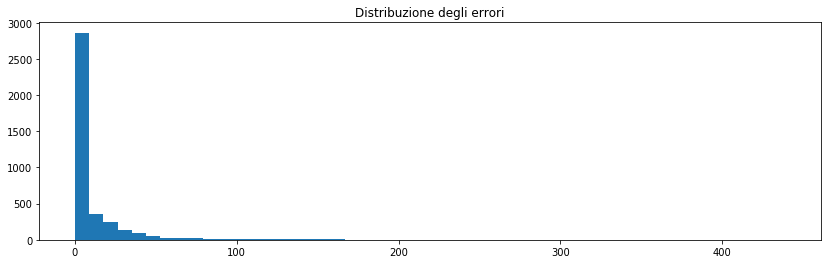

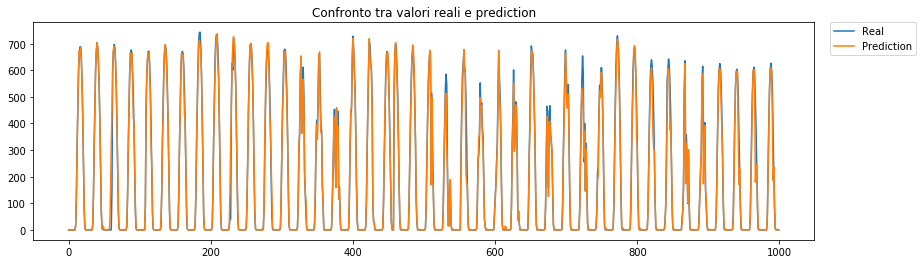

In [15]:
# Calcola l'errore come scostamento delle predizioni dal valore reale
errors = np.abs(validation_y - validation_y_predicted) 

plt.figure(figsize=(14, 4))
plt.title("Distribuzione degli errori")
plt.hist(x = errors, bins=50)
plt.show()

# Visualizza l'andamento reale e quello predetto
plt.figure(figsize=(14, 4))
plt.title("Confronto tra valori reali e prediction")
plt.plot(validation_y[0:1000], label='Real')
plt.plot(validation_y_predicted[0:1000], label='Prediction')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Ottimizzazione dei parametri
Si consideri ora lo scenario *predict ahead*, in cui viene richiesto di predire la potenza prodotta dall'impianto fotovoltaico durante l'ora successiva. Si metta in pratica quanto appreso nei passi precedenti al fine di identificare il regressore e i relativi iperparametri in grado di ottimizzare l'RMSE sul dataset di test.

È possibile procedere considerando la possibilità di eseguire un'opportuna *Cross-Validation* utilizzando fold composte sia da periodi temporali ordinati che fold con pattern selezionati casualmente. Qualora si desideri procedere senza *Cross-Validation* si consiglia di suddividere il dataset originale per ottenere un set di training e uno di validation.

Si consideri inoltre che sia [**GridSearchCV(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) che [**cross_val_score(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) utilizzano internamente il meotodo **.score(...)** dell'istanza del regressore per ottenere il punteggio $R^{2}$ relativo alla bontà della regressione. Al fine di utilizzare MSE come punteggio è sufficiente istanziare **GridSearchCV(...)** con il parametro *scoring* impostato al valore *'neg_mean_squared_error'* (stringa). Lo stesso si applica a **cross_val_score(...)**. Per poter ottenere l'RMSE a partire dai punteggi ottenuti durante la *grid search* è sufficiente applicare **np.sqrt(...)** a *-gscv.best\_score\_* e *-gscv.cv\_results\_\['mean_test_score'\]*.

Si inizi valutando quali dati inserire nel dataset (eventualmente ri-eseguendo la fase di caricamento e *preprocessing*) per poi preparare i dati così ottenuti allo scenario *predict ahead*.

In [16]:
# Ottimizzazione con Cross-Validation

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
reg = RandomForestRegressor() 

param_grid = [{'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'random_state': [1234]}]

# Con shuffle=False si otterranno fold temporalmente ordinate
# (se i pattern non sono stati precedentemente mescolati)
experiment_gscv = GridSearchCV(reg, param_grid, \
                               cv=KFold(n_splits=4, shuffle=False), \
                               scoring='neg_mean_squared_error')

experiment_gscv.fit(data_x, data_y)

# Stampa risultati
print('Combinazioni di parametri:\n', experiment_gscv.cv_results_['params'])
print('RMSE medio per combinazione:\n', np.sqrt(-experiment_gscv.cv_results_['mean_test_score']))
print('Combinazione migliore:\n', experiment_gscv.best_params_)
print('RMSE medio della combinazione migliore: %.3f' % np.sqrt(-experiment_gscv.best_score_))

Combinazioni di parametri:
 [{'max_depth': None, 'n_estimators': 10, 'random_state': 1234}, {'max_depth': None, 'n_estimators': 50, 'random_state': 1234}, {'max_depth': None, 'n_estimators': 100, 'random_state': 1234}, {'max_depth': 2, 'n_estimators': 10, 'random_state': 1234}, {'max_depth': 2, 'n_estimators': 50, 'random_state': 1234}, {'max_depth': 2, 'n_estimators': 100, 'random_state': 1234}, {'max_depth': 3, 'n_estimators': 10, 'random_state': 1234}, {'max_depth': 3, 'n_estimators': 50, 'random_state': 1234}, {'max_depth': 3, 'n_estimators': 100, 'random_state': 1234}]
RMSE medio per combinazione:
 [41.1405005  40.9451768  40.92633728 55.23739094 55.21069866 55.43370515
 43.58940552 43.26013755 43.33824939]
Combinazione migliore:
 {'max_depth': None, 'n_estimators': 100, 'random_state': 1234}
RMSE medio della combinazione migliore: 40.926


In [17]:
# Verifica dei parametri trovati (utilizzando cross_val_score o il validation set)

# reg = LinearRegression()
reg = RandomForestRegressor(**experiment_gscv.best_params_)

scores = np.sqrt(-cross_val_score(reg, data_x, data_y, cv=KFold(n_splits=4, shuffle=False), scoring='neg_mean_squared_error'))
print('RMSE Cross Validation:', scores, '\nAverage:', np.mean(scores))

RMSE Cross Validation: [32.18149729 57.78299867 34.92583251 33.24940378] 
Average: 39.53493306450798


# Test
Si addestri il regressore desiderato utilizzando gli iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale regressore per predire la potenza prodotta nell'ora successiva a partire dai pattern del dataset di test. I valori predetti verranno memorizzati su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'RMSE.

In [18]:
# Esercizio 2: valutazione su test set

test_path = 'test.txt'
result_path = 'Es5Predictions.txt'

# Caricamento dei pattern di test
test_dataframe = pd.read_csv(test_path)
test_datetime_strings = test_dataframe.values[:,1]
test_datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in test_datetime_strings]

# Estrae alcune informazioni dagli oggetti Timestamp
test_month = [datetime.month for datetime in test_datetimes]
test_yday = [datetime.timetuple().tm_yday for datetime in test_datetimes]

# test_x conterrà tutti i pattern (esclusi Time Frame, Data e Potenza prodotta)
# Reminder: colonna 0 = Time Frame, colonna 1 = date, colonna 6 = potenza prodotta
test_x = test_dataframe.values[:,2:6]

#test_x = np.c_[test_x, test_dataframe.values[:,0]] # Include solamente il Time Frame
test_x = np.c_[test_x, test_dataframe.values[:,0], test_month] # Include il Time Frame e il mese
#test_x = np.c_[test_x, test_dataframe.values[:,0], test_yday] # Include il Time Frame e il giorno dell'anno

# Cast di tutti i valori a float32
test_x = test_x.astype(np.float32)

# Creazione e addestramento classificatore
reg = RandomForestRegressor(**experiment_gscv.best_params_) 

print('Addestramento in corso ...')
reg.fit(data_x, data_y)

# Salvataggio delle predictions
predictions = reg.predict(test_x)
np.savetxt(result_path, predictions)
print('Ok')

Addestramento in corso ...
Ok
